In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Chapter 8 Exercises

## Conceptual

**1.** Draw an example (of your own invention) of a partition of two- dimensional feature space that could result from recursive binary splitting. Your example should contain at least six regions. Draw a decision tree corresponding to this partition. Be sure to label all aspects of your figures, including the regions $R1, R2, . . .,$ the cutpoints $t1,t2,...,$ and so forth.

*_Hint: Your result should look something like Figures 8.1 and 8.2._*

                   x1<=5
                   |    |
             x2<=1.5    x1<=11  
             |     |    |    |
        x1<=2.5   22    14    x2<=4
       |      |              |     | 
       55    42              25    7

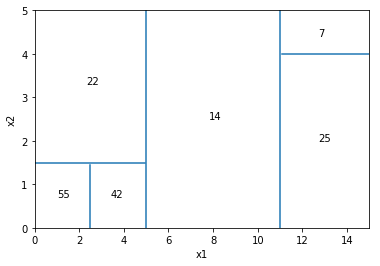

In [98]:
# A partition of the predictor space

# split lines
plt.axhline(y=4, xmin=1, xmax=0.74)
plt.axvline(x=5)
plt.axvline(x=2.5, ymin=0, ymax=0.29)
plt.axvline(x=11)
plt.axhline(y=1.5, xmin=0, xmax=0.33)

# axis and labels
plt.axis([0,15,0,5])
plt.xlabel("x1")
plt.ylabel("x2")

# label terminal nodes
plt.text(1, 0.7, '55')
plt.text(3.4, 0.7, '42')
plt.text(2.3, 3.3, '22')
plt.text(7.8, 2.5, '14')
plt.text(12.7, 2, '25')
plt.text(12.7, 4.4, '7')
plt.show();

**2.** It is mentioned in Section 8.2.3 that boosting using depth-one trees (or stumps) leads to an additive model. Explain why this is the case.

>Additive models are a sum of univariate regression functions over the variables (in the regression case). Similarly, boosting using depth-one trees is a sum of single variable models.

**3.** Consider the Gini index, classification error, and cross-entropy in a simple classification setting with two classes. Create a single plot that displays each of these quantities as a function of ${\hat p}_{m1}$. The x-axis should display ${\hat p}_{m1}$, ranging from 0 to 1, and the y-axis should display the value of the Gini index, classification error, and entropy.

In [113]:
p = np.linspace(0.0001, 0.9999, 100)

gini = p*(1-p)*2
entropy = -(p * np.log(p) + (1 - p) * np.log(1 - p))
class_err = 1 - np.maximum(p, 1 - p)

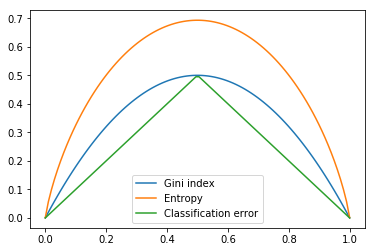

In [120]:
plt.plot(p, gini)
plt.plot(p, entropy)
plt.plot(p, class_err)
plt.legend(('Gini index', 'Entropy', 'Classification error'),loc='best');

**4.** See answer to question 1.

**5.** Suppose we produce ten bootstrapped samples from a data set containing red and green classes. We then apply a classification tree to each bootstrapped sample and, for a specific value of X, produce 10 estimates of P(Class is Red|X).

There are two common ways to combine these results together into a single class prediction. One is the majority vote approach discussed in this chapter. The second approach is to classify based on the average probability. In this example, what is the final classification under each of these two approaches?

In [140]:
p_red = [0.1, 0.15, 0.2, 0.2, 0.55, 0.6, 0.6, 0.65, 0.7, 0.75]

# majority vote
print(sum(1 for i in p_red if i>=0.5)/len(p_red))

# average
print(np.average(p_red))

0.6
0.45


**6.** Provide a detailed explanation of the algorithm that is used to fit a regression tree.

First, we select the predictor $X_j$ and the cutpoint $s$ such that splitting the predictor space into the regions ${X|X_j<s}$ and ${X|X_j>=s}$ leads to the greatest possible reduction in RSS.

Next, we repeat the process, looking for the best predictor and best cutpoint in order to split the data further so as to minimize the RSS within each of the resulting regions.

This process continues until a stopping point is reached; for instance, we may continue until no region contains more that five observations.

Once the regions have been created, we predict the response for a given test observation using the mean of the training observations in the region to which that test observation belongs.